In [2]:
pip install fuzzywuzzy


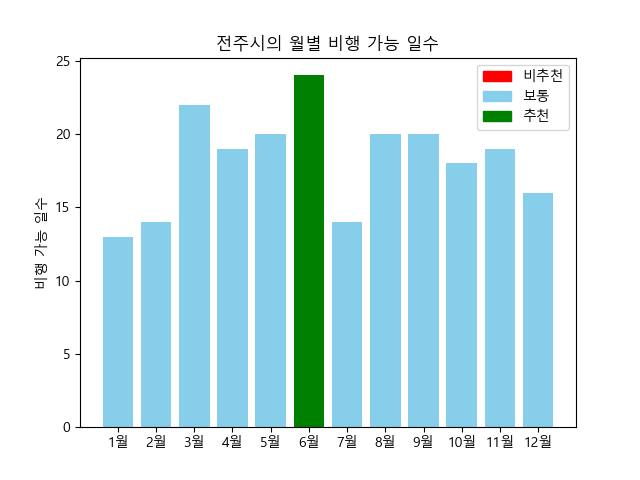
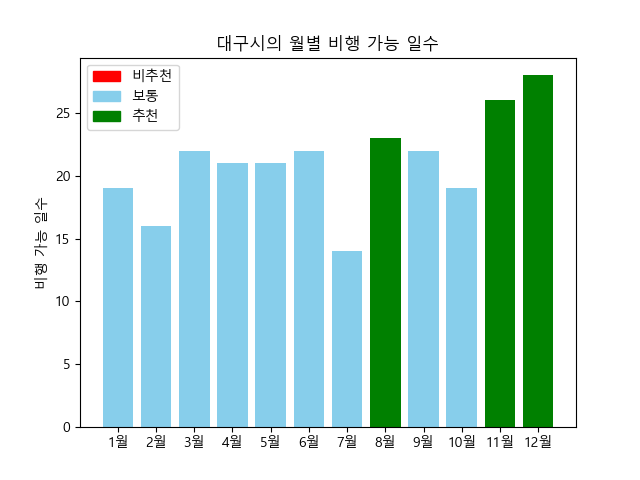
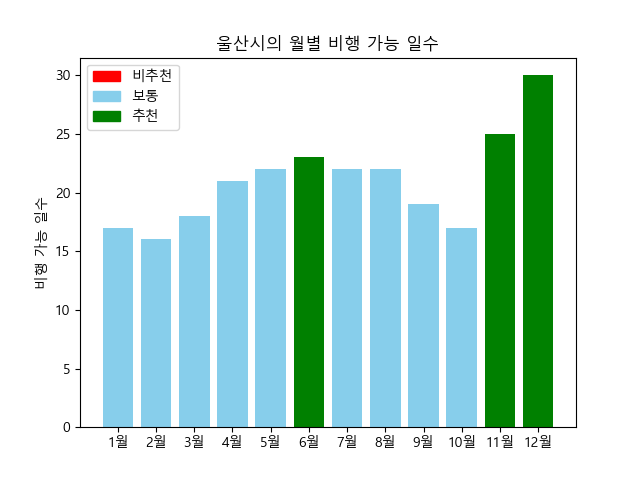
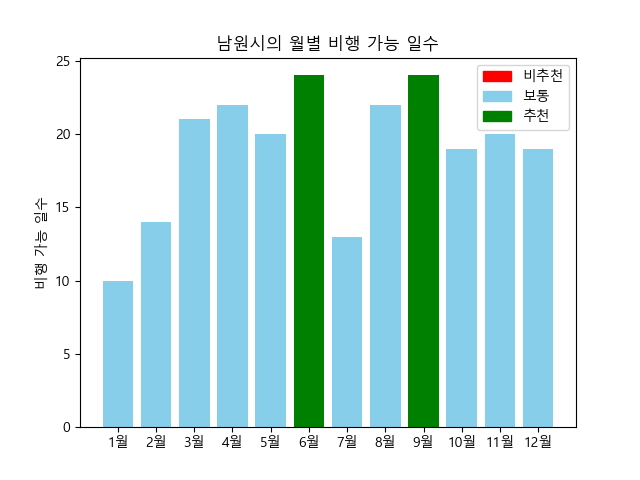
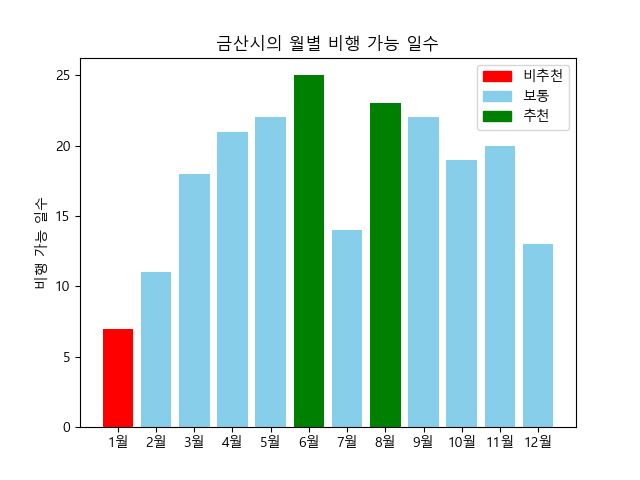
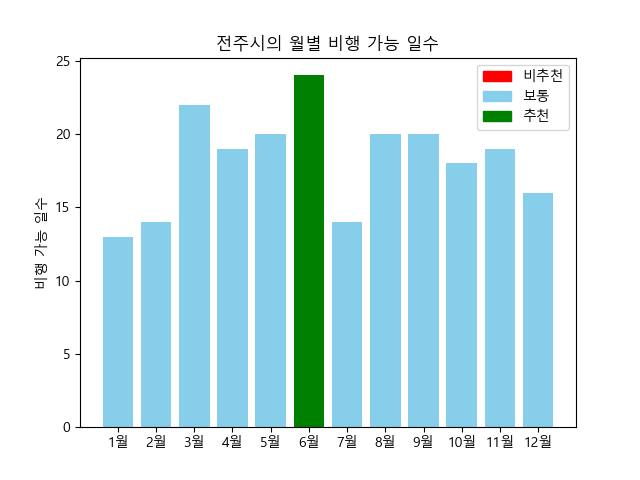
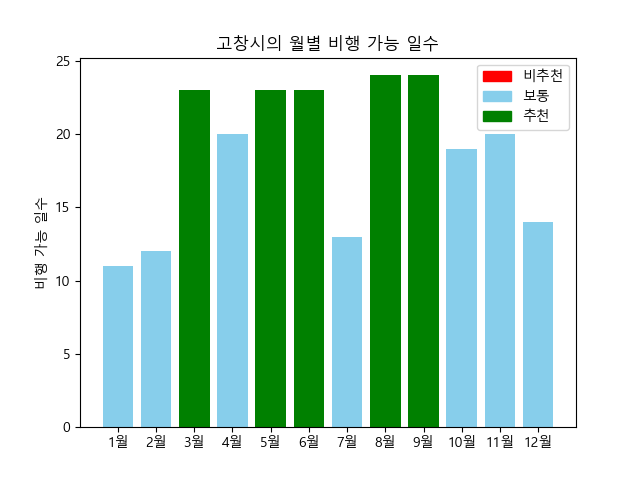
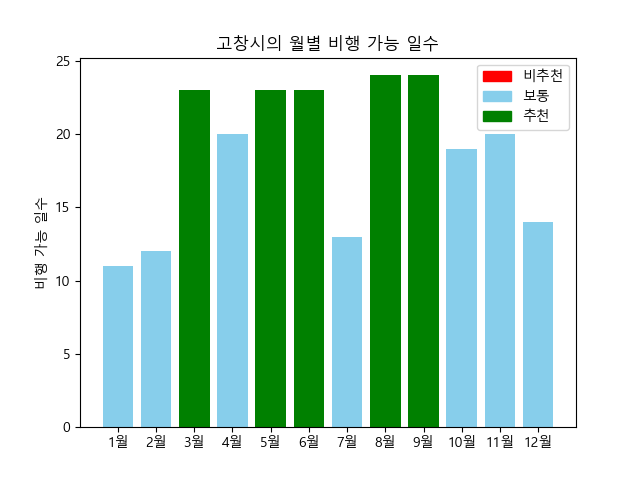
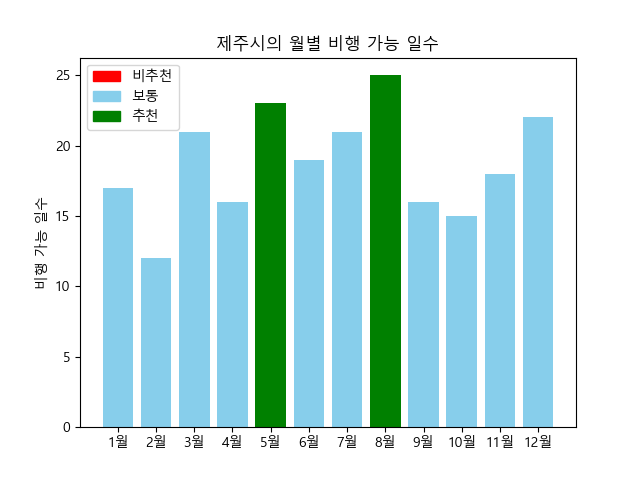
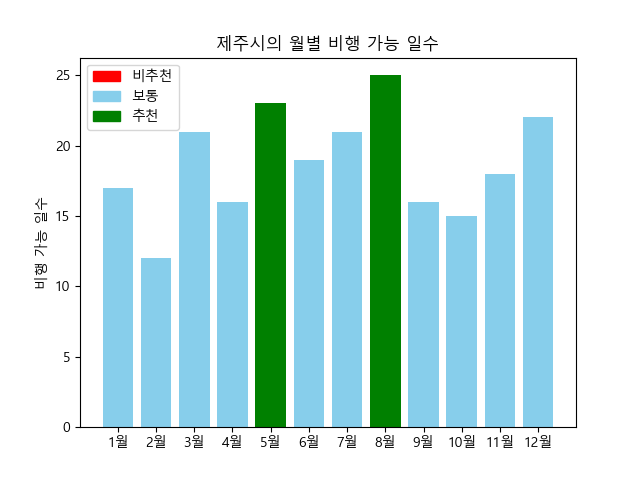
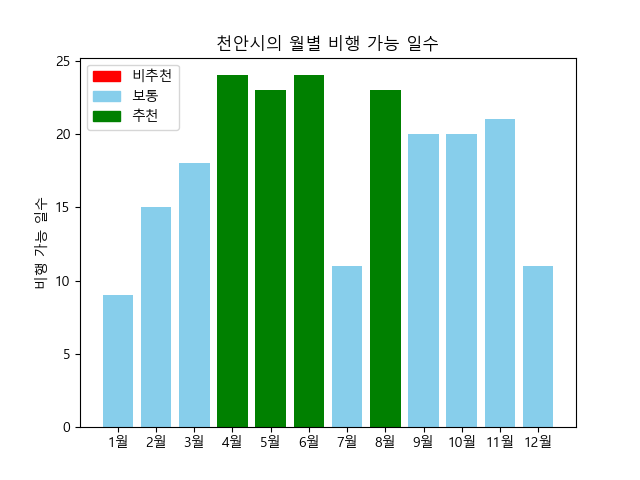
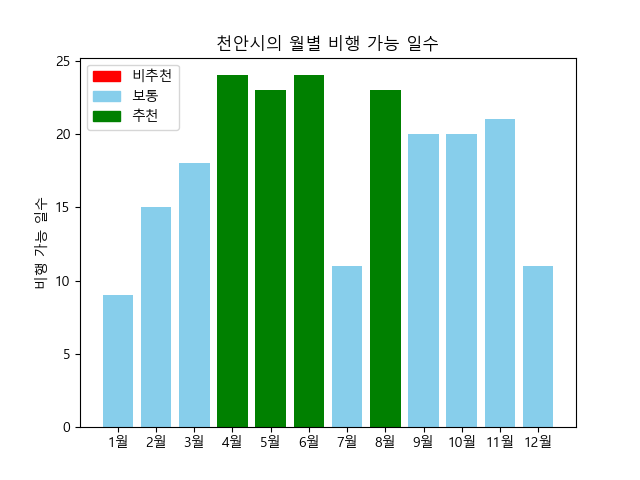
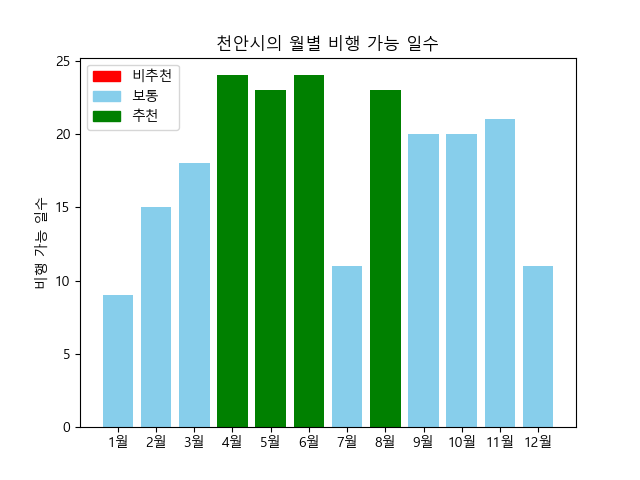
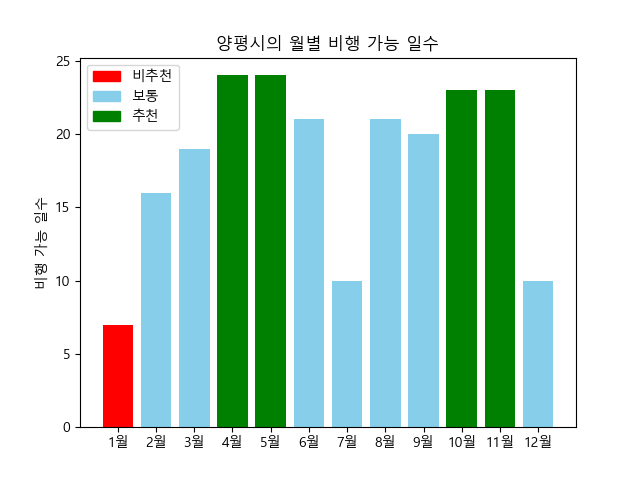
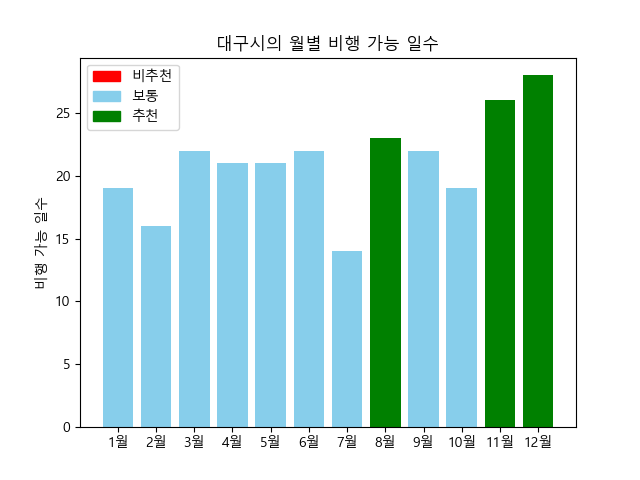
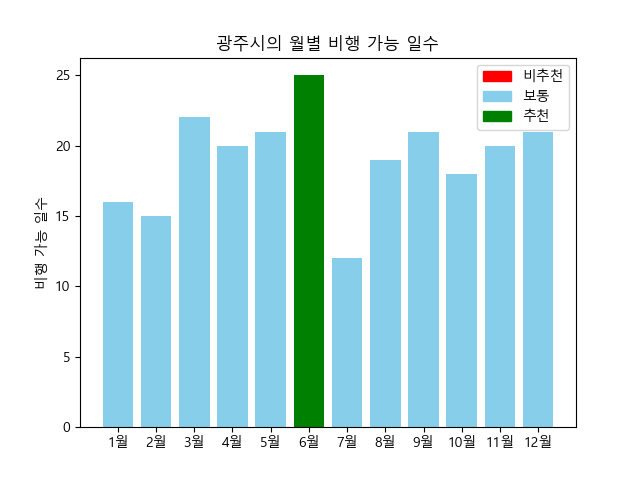
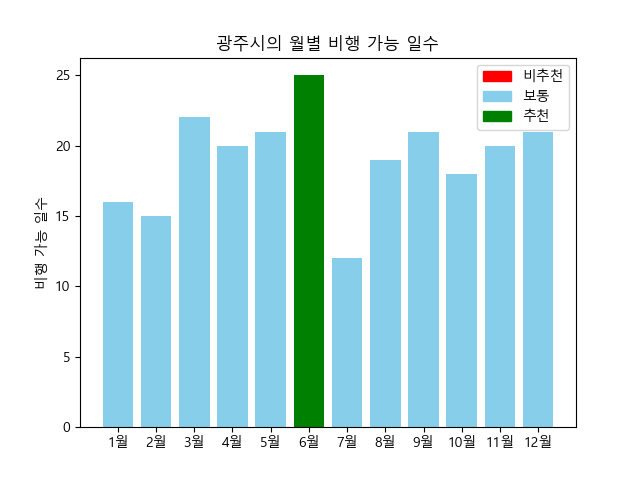
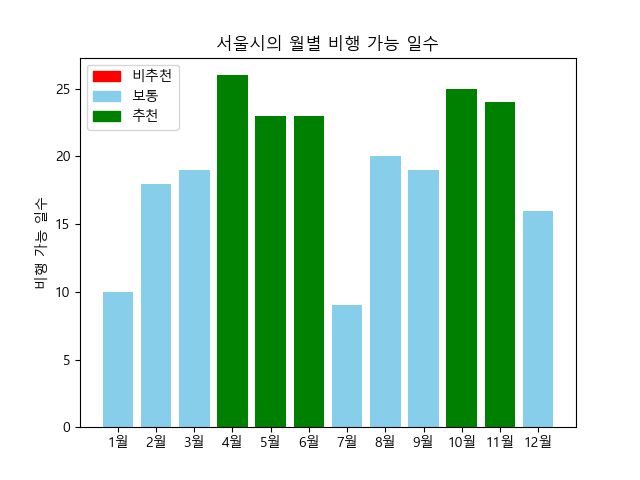
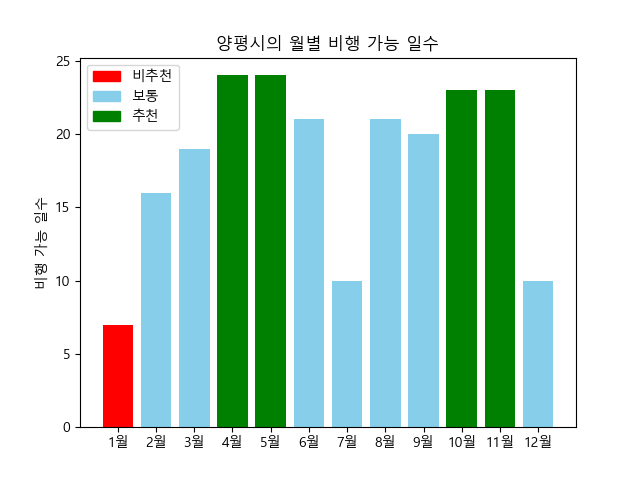
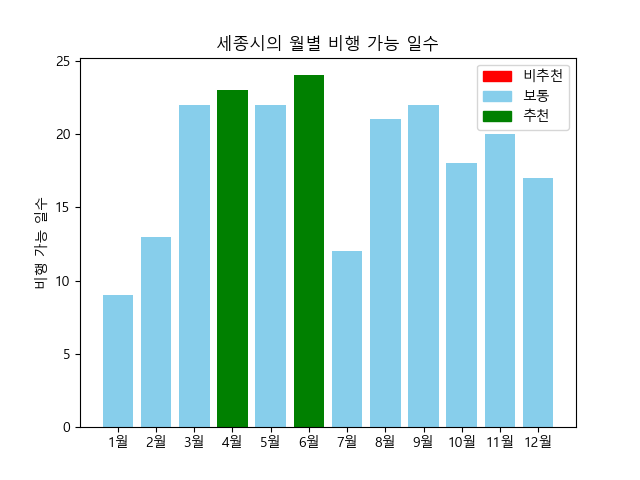
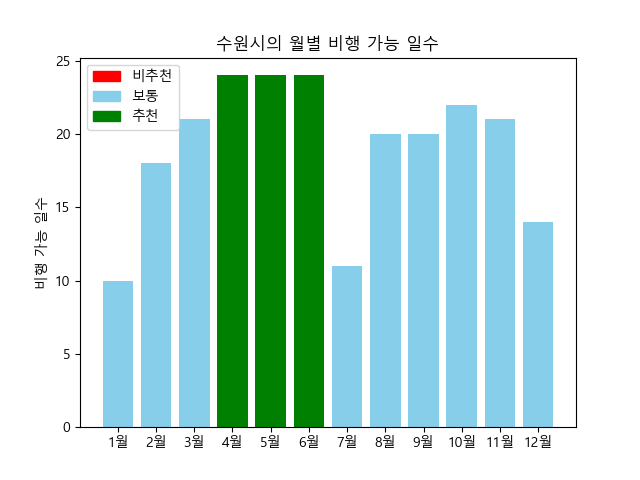
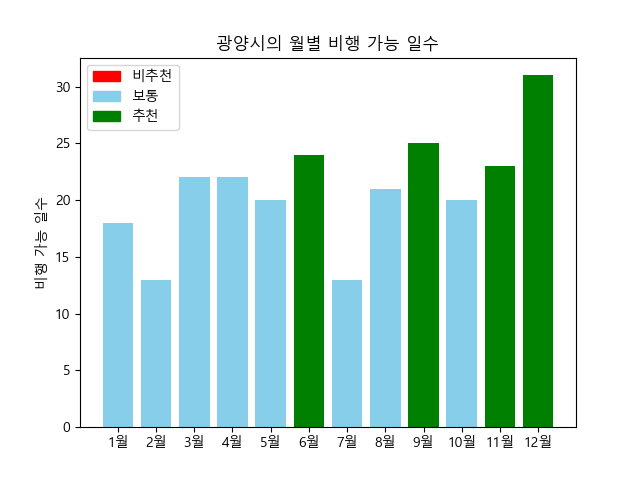
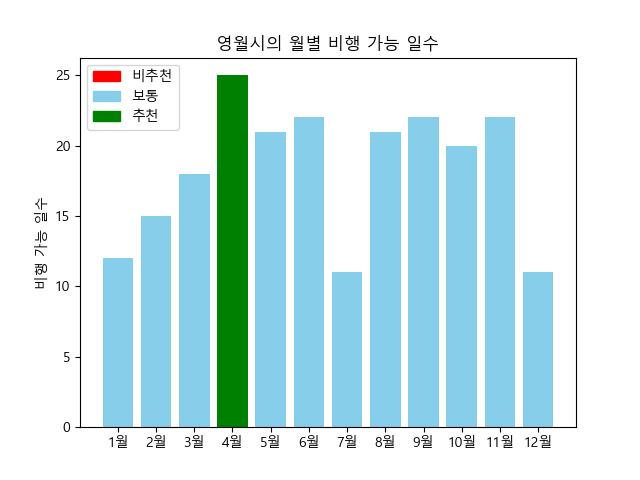
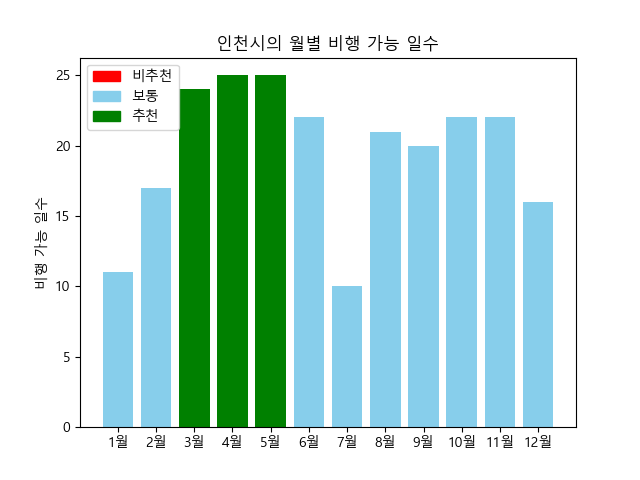
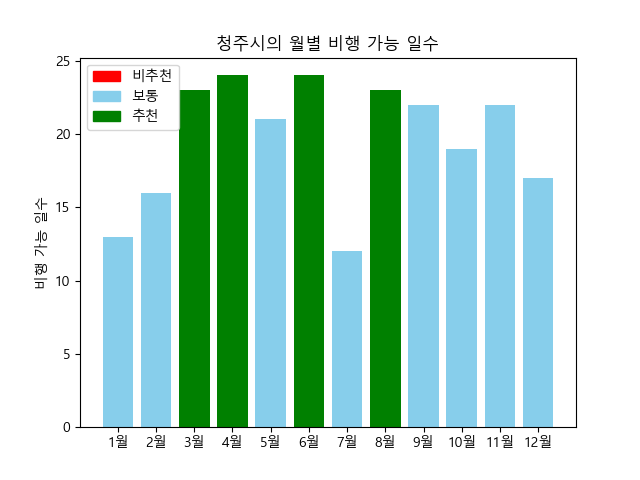
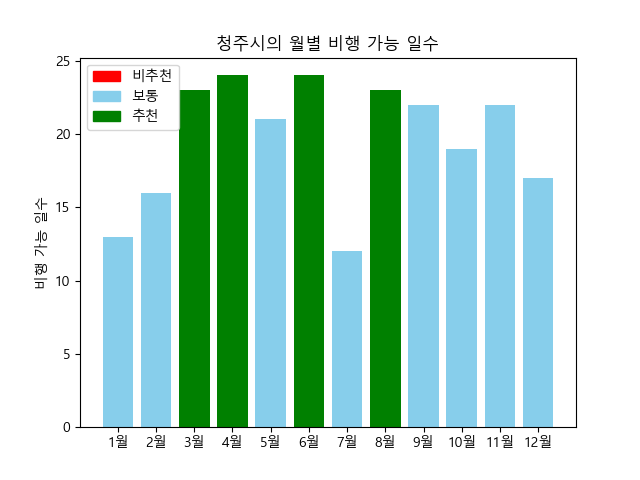
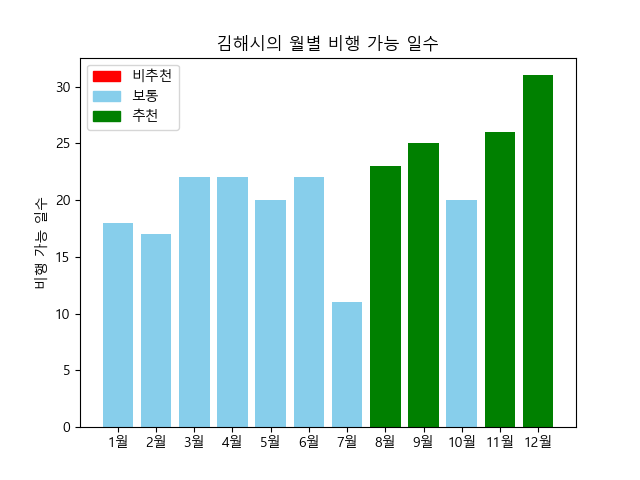
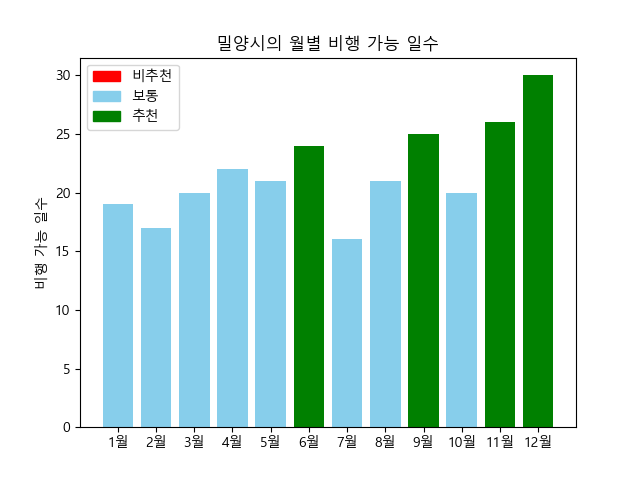
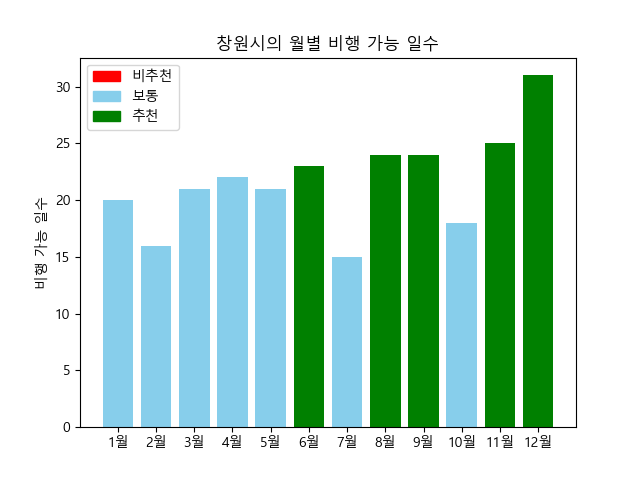
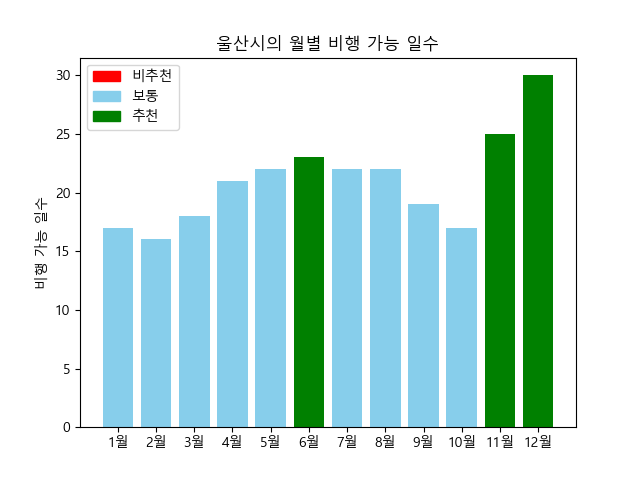
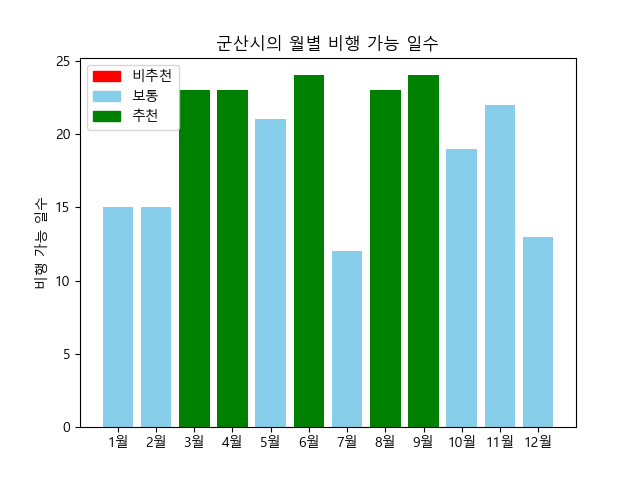
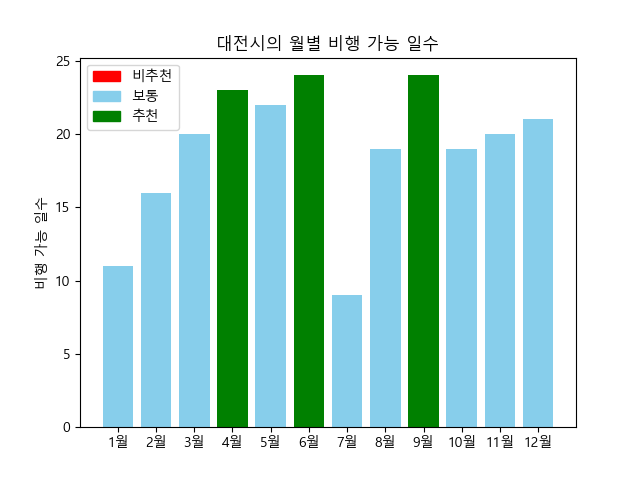
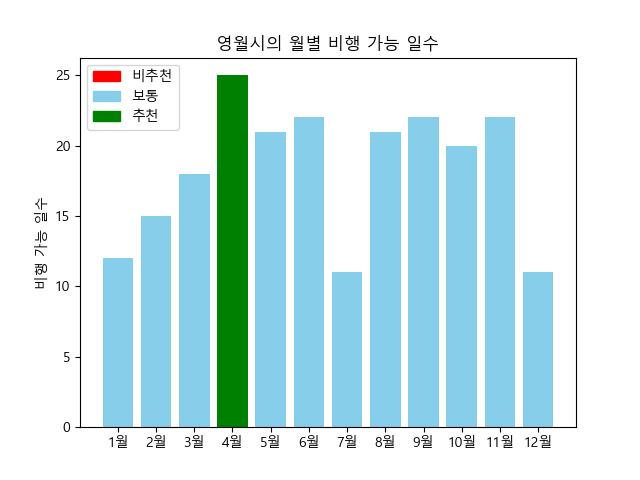
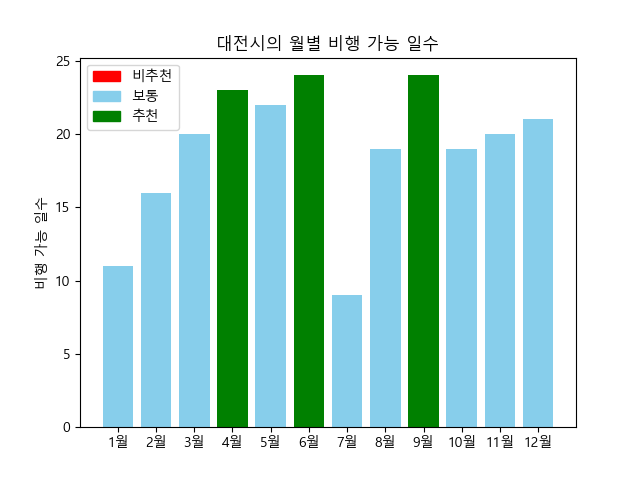
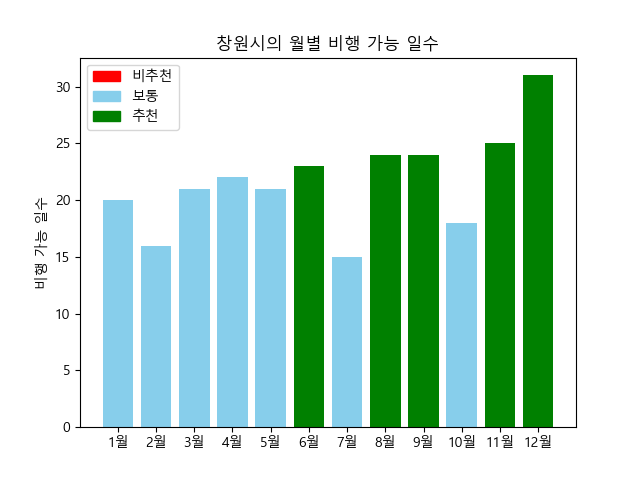
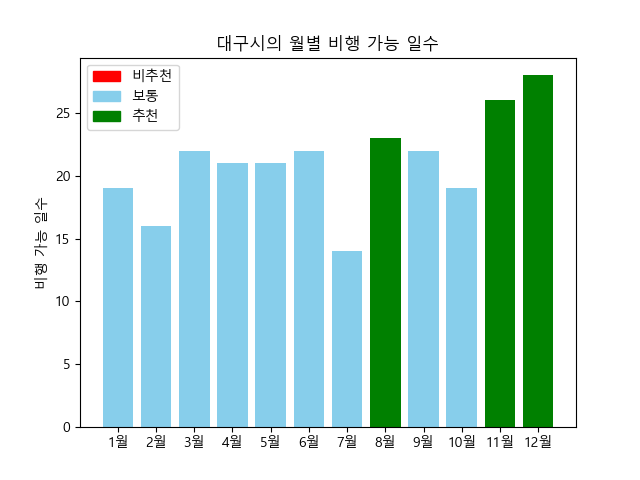
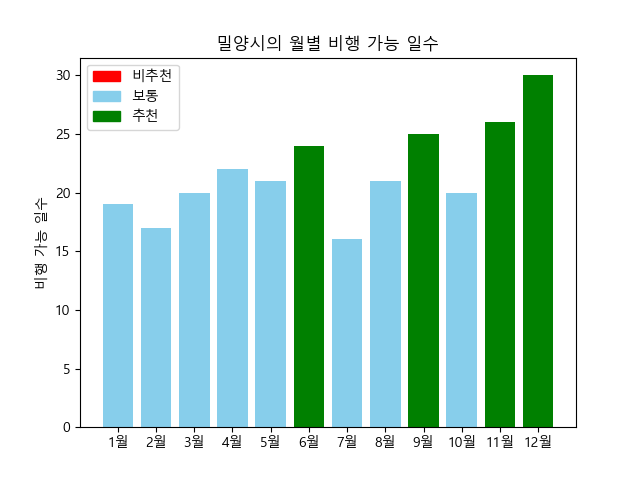
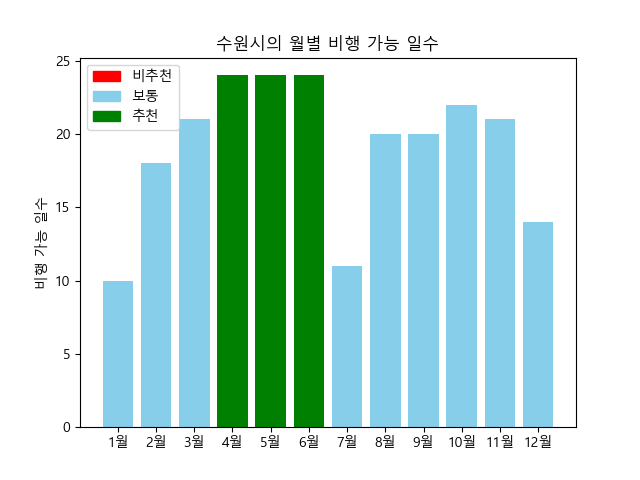
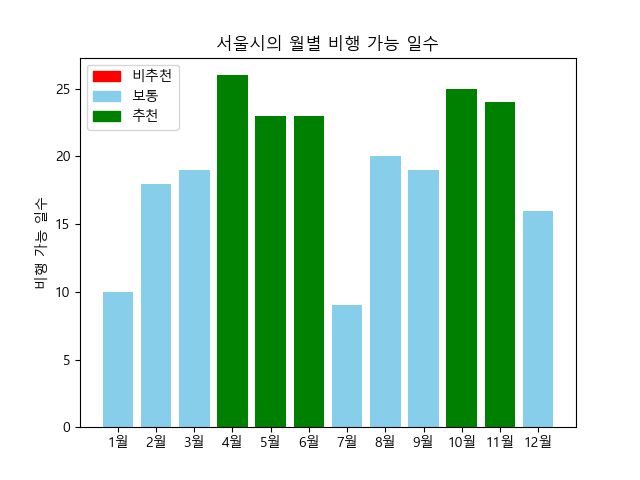
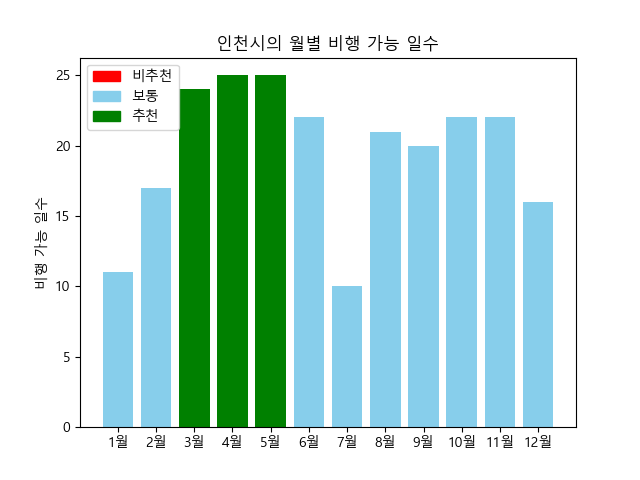
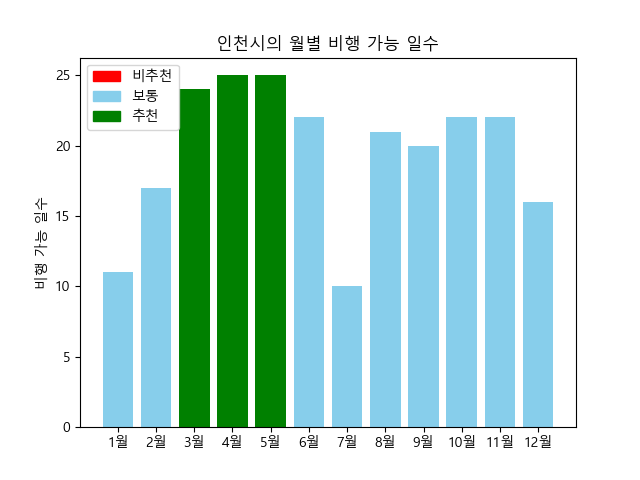
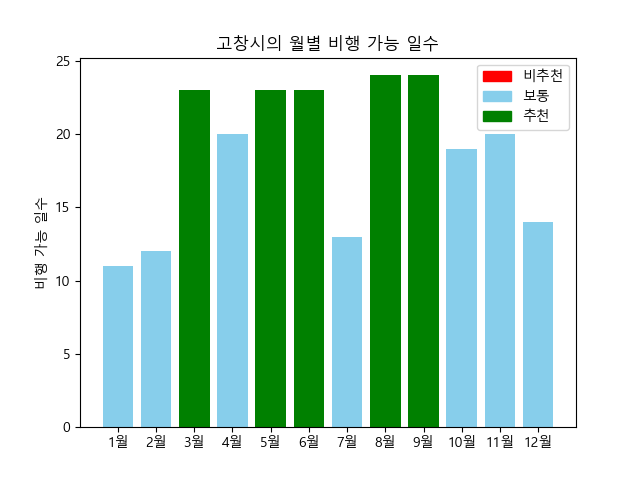
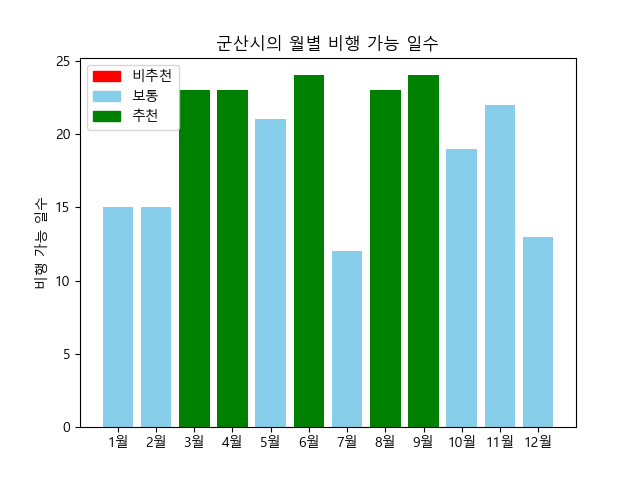
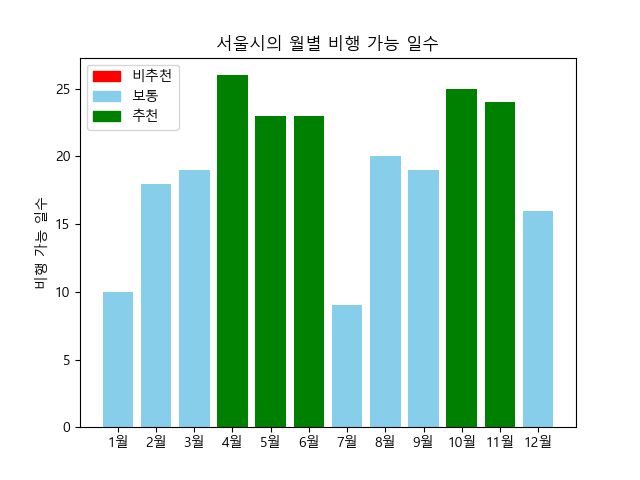
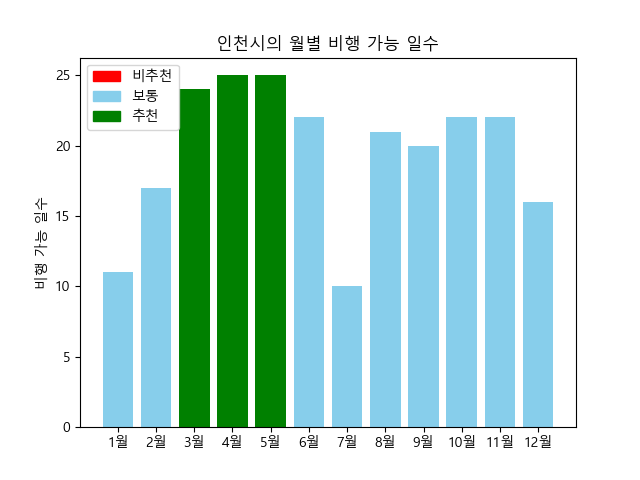
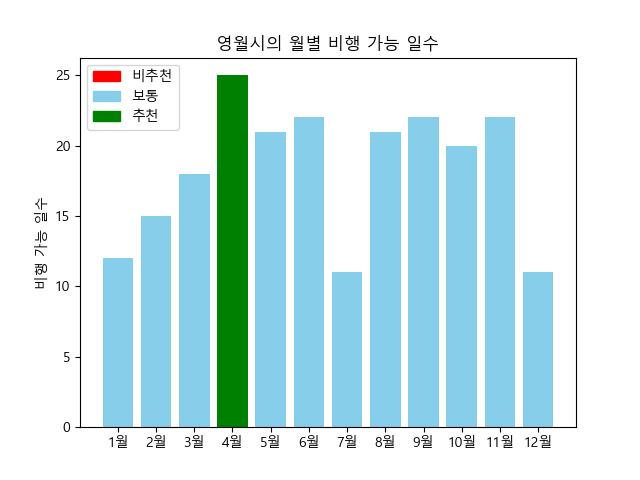
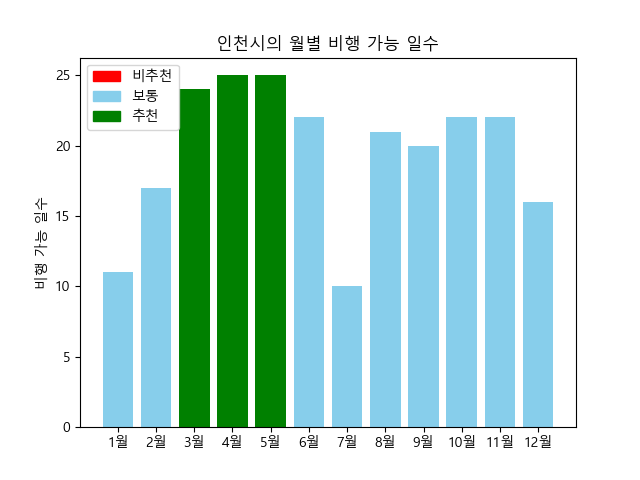
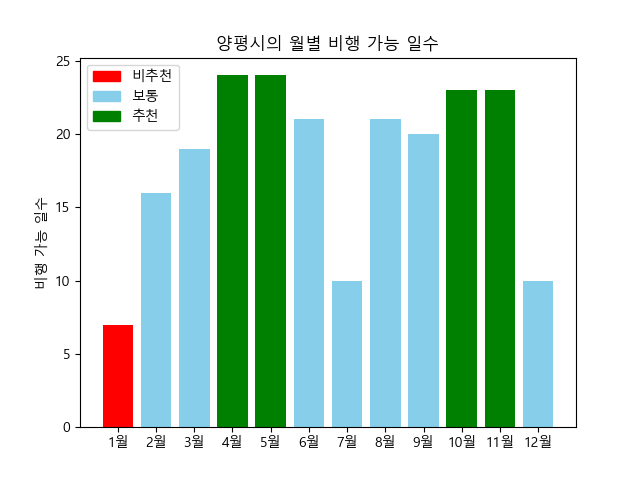
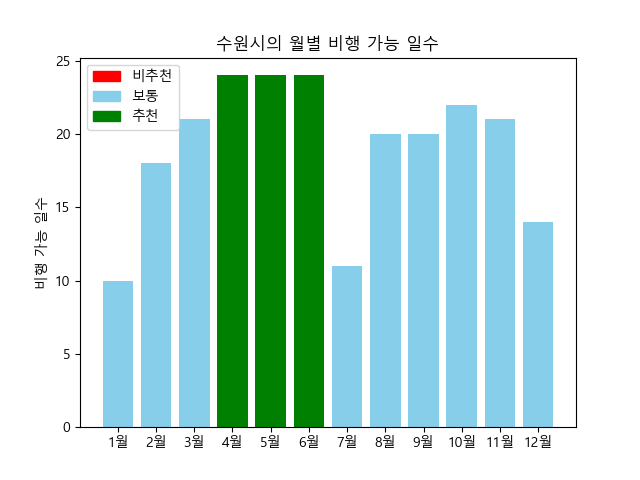
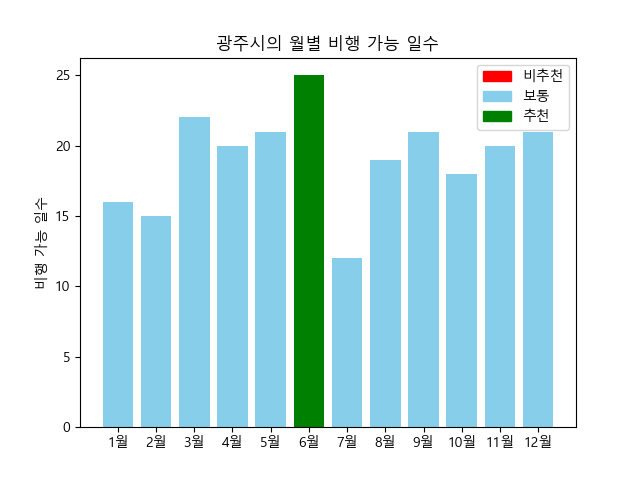
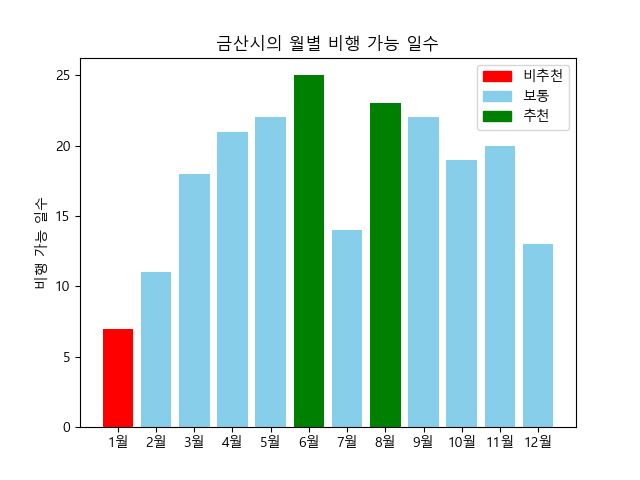
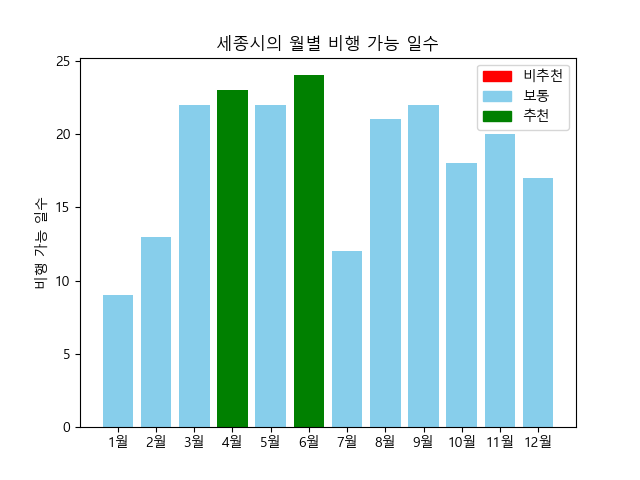
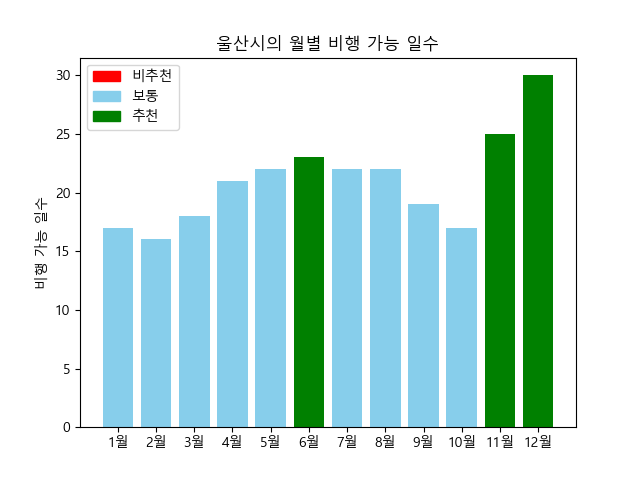
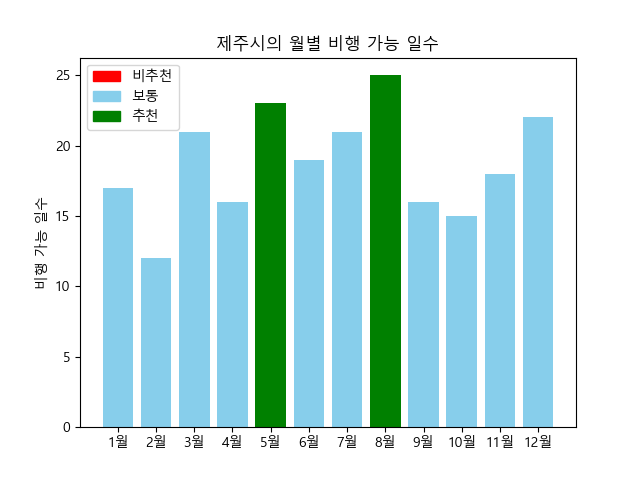
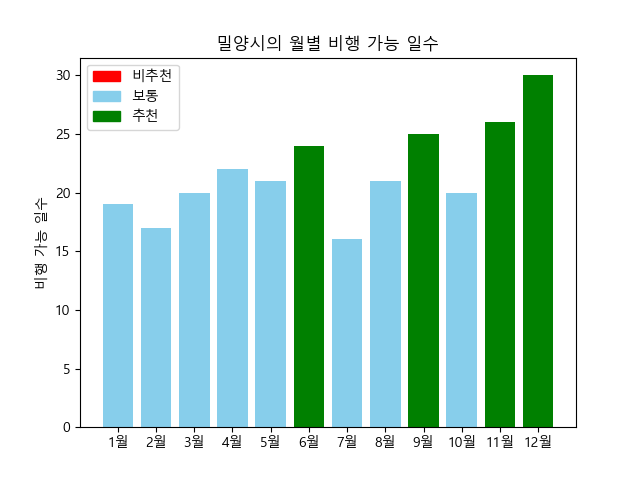
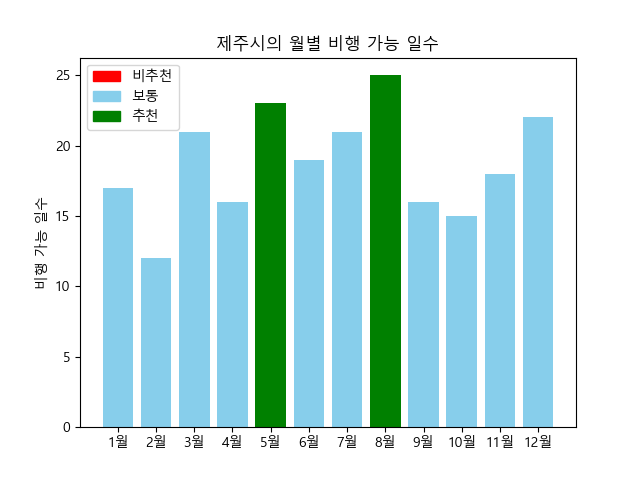
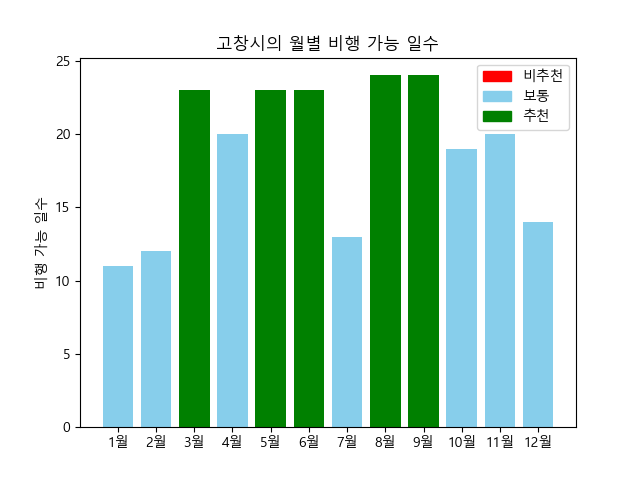
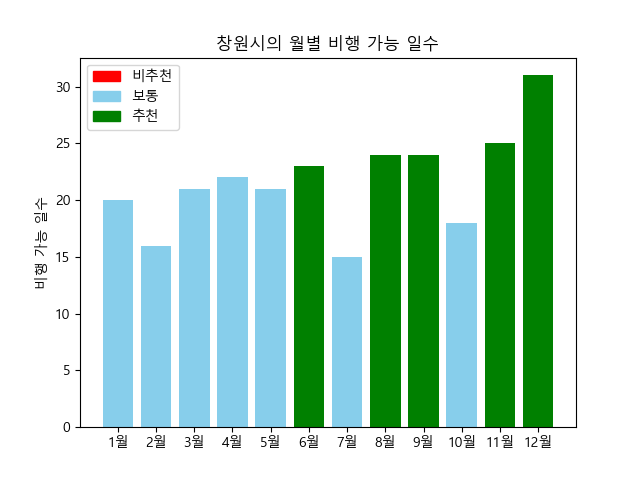
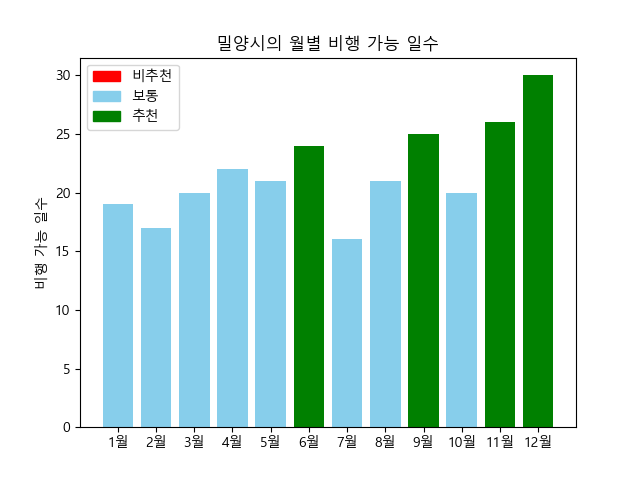
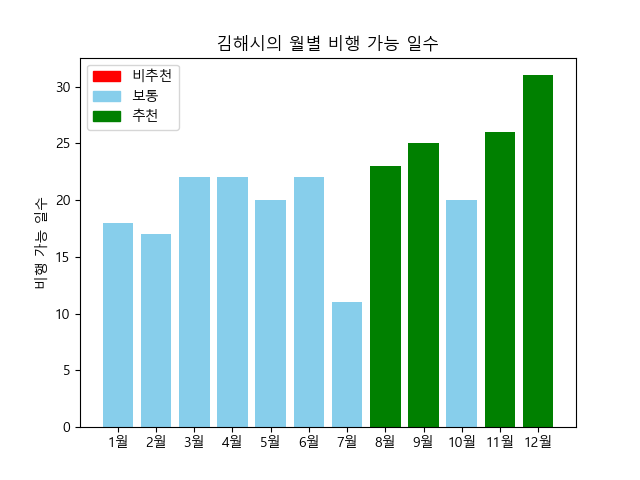
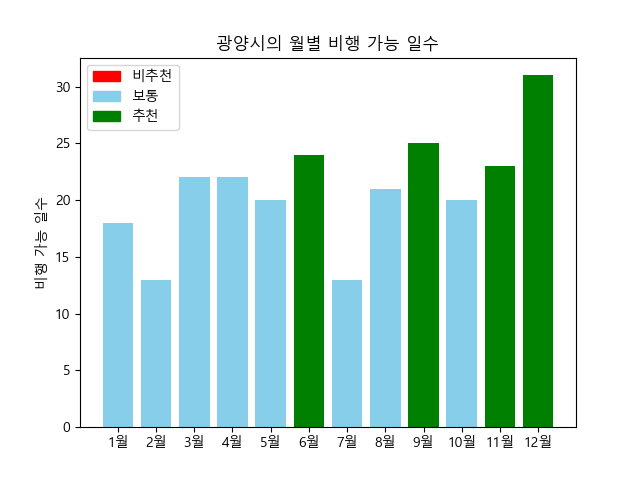
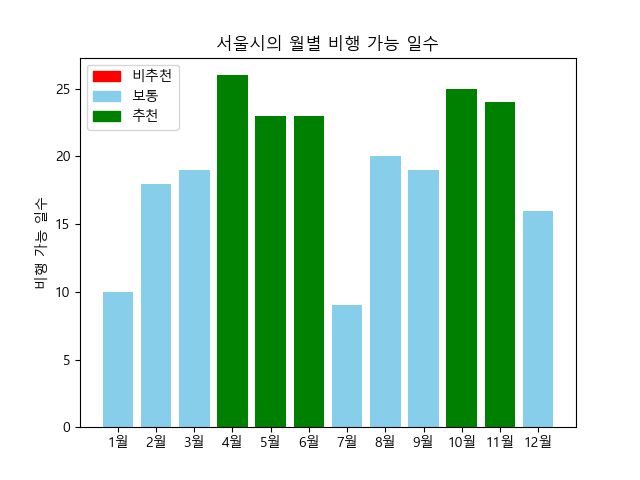
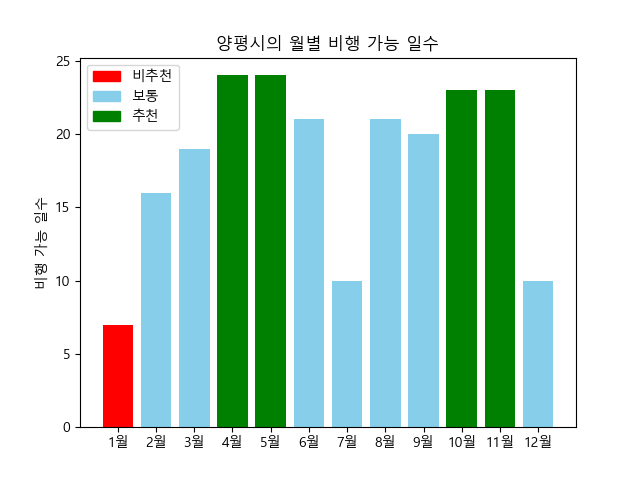
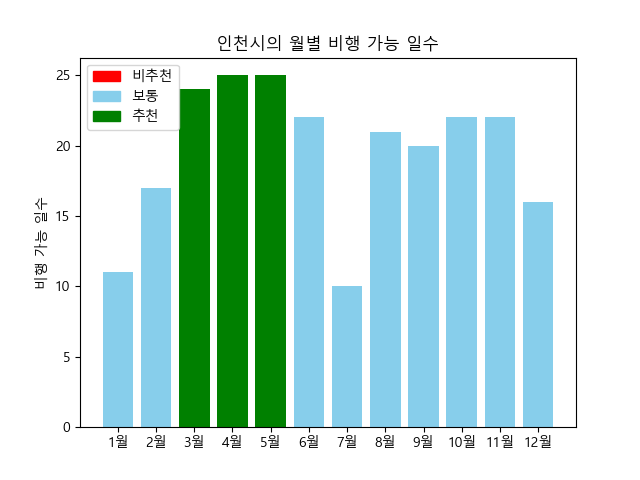
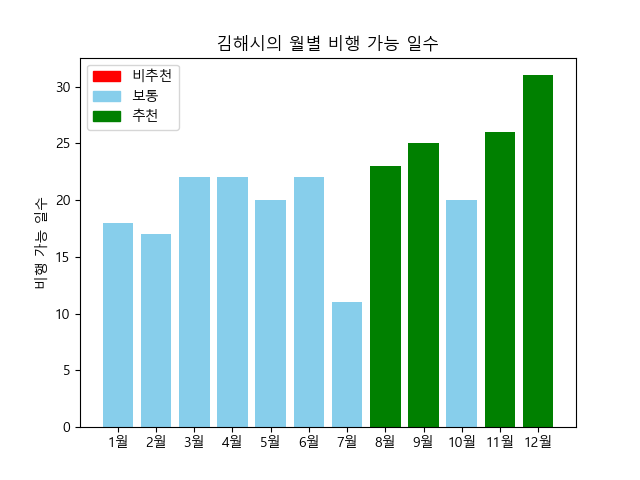
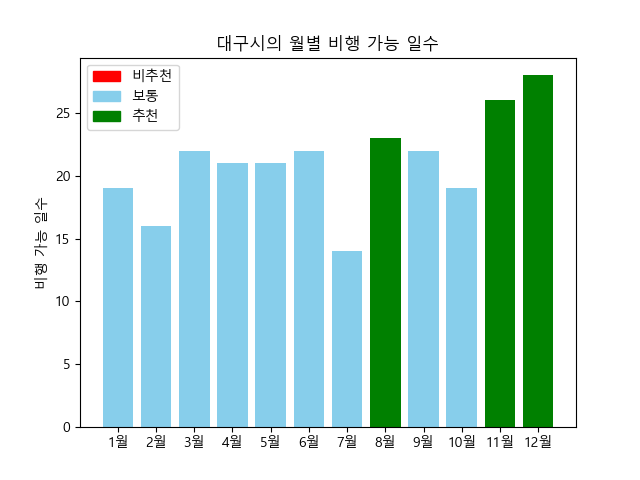
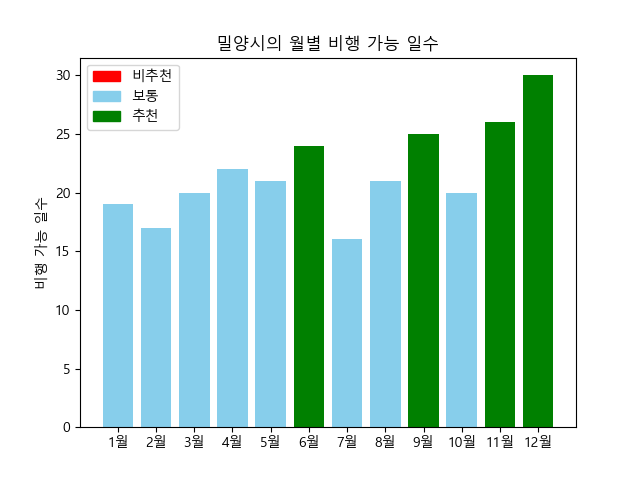
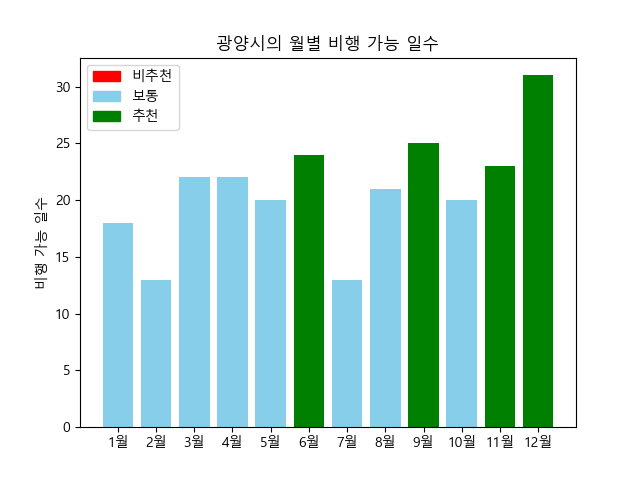
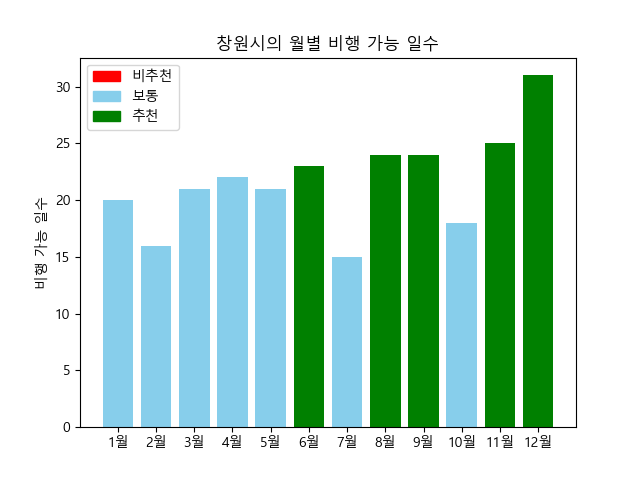
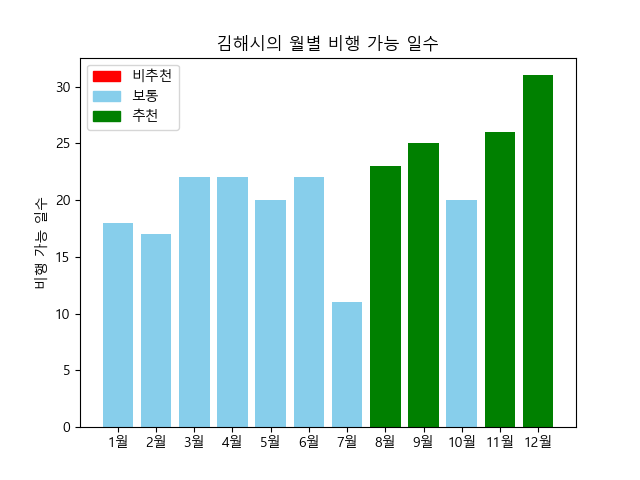

In [9]:
import os  # 운영체제 관련 기능(파일 경로 처리나 디렉터리 작업 위해)
import ast # 문자열로 표현된 파이썬 리터럴(예: 리스트, 튜플 등)을 안전하게 실제 객체로 변환하기 위해 사용
           # -> NE_table의 NE 열에서 다각형 좌표 데이터를 문자열에서 리스트로 변환할 때 ast.literal_eval()로 사용
import pandas as pd
import folium
import base64 #matplotlib로 생성한 그래프 이미지를 base64 형식으로 인코딩하여 HTML 팝업에 삽입하기 위해 사용
from io import BytesIO  #메모리 내에서 바이너리 데이터를 저장하는 스트림 객체를 생성
from fuzzywuzzy import process  # 문자열 간 유사도 비교를 위한 함수들을 제공
                                # -> weather_yn_df의 stnNm과 다른 테이블의 지역명(clean_location) 사이의 매칭을 위해 process.extractOne()을 사용
import re  # 정규 표현식을 사용하여 문자열 패턴을 검색, 치환하는 데 사용
           # -> 지역명에서 괄호 안의 내용을 제거
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json #JSON 형식의 데이터를 파싱하거나 생성할 때 사용(여기서 직접적인 사용하지는 X)

# 경고 메시지 무시 및 한글 깨짐 방지용 폰트 설정
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

# =============================================================================
# 1. CSV 파일 불러오기
# =============================================================================
# circle_table: 원형 비행구역 정보 (위치, 위도, 경도, 반경 등)
# NE_table: 다각형 비행구역 정보 (위치, 다각형 좌표 NE)
# weather_yn_df: 각 지역의 월별 비행 가능 일수 (stnNm, yyyymm, yn_month 등)
circle_table = pd.read_csv("C:/Users/kny/스마트국방_Pandas수업/웹크롤링/Circle_table.csv", encoding="utf-8")
NE_table = pd.read_csv("C:/Users/kny/스마트국방_Pandas수업/웹크롤링/NE_table.csv", encoding="utf-8")
weather_yn_df = pd.read_csv("C:/Users/kny/스마트국방_Pandas수업/웹크롤링/weather_yn_df.csv", encoding="utf-8")

# =============================================================================
# 2. 데이터 전처리: 공백 제거 및 지역명 단순화
# =============================================================================
# 각 데이터프레임에서 위치 관련 열의 공백 제거
weather_yn_df['stnNm'] = weather_yn_df['stnNm'].str.strip()
circle_table['위치'] = circle_table['위치'].str.strip()
NE_table['위치'] = NE_table['위치'].str.strip()

# 괄호 안의 내용 제거해서 간단한 지역명 만들기 (예: "전주(홍산)" → "전주")
def clean_location(name):
    return re.sub(r"\(.*?\)", "", name).strip()

circle_table['clean_location'] = circle_table['위치'].apply(clean_location)
NE_table['clean_location'] = NE_table['위치'].apply(clean_location)

# "시"라는 접미어 추가 (이미 "시"가 있으면 추가하지 않음)
def add_city_suffix(name):
    if name and not name.endswith("시"):
        return name + "시"
    return name

weather_yn_df['stnNm'] = weather_yn_df['stnNm'].apply(add_city_suffix)
circle_table['clean_location'] = circle_table['clean_location'].apply(add_city_suffix)
NE_table['clean_location'] = NE_table['clean_location'].apply(add_city_suffix)

# =============================================================================
# 3. fuzzywuzzy를 사용해 weather_yn_df의 stnNm과 다른 테이블의 clean_location 매칭
# =============================================================================
# valid_locations: circle_table과 NE_table의 모든 지역명을 합친 집합
valid_locations = list(set(circle_table['clean_location']).union(set(NE_table['clean_location'])))

# stnNm과 valid_locations 간 유사도 매칭 (70% 이상이면 매칭된 결과 반환)
def get_best_match(x):
    match = process.extractOne(x, valid_locations, score_cutoff=70)
    return match[0] if match else None

# weather_yn_df에 matched_location 컬럼 추가 → 이 값으로 이후 지도 및 그래프 연결
weather_yn_df['matched_location'] = weather_yn_df['stnNm'].apply(get_best_match)

# =============================================================================
# 4. 그래프 생성 함수: 각 지역의 월별 비행 가능 일수를 막대그래프로 생성
# =============================================================================
# graph_cache를 사용하여 이미 생성된 그래프를 재사용 (성능 최적화)
graph_cache = {}

def create_graph(region_name, data):
    """
    region_name: 해당 지역명 (matched_location)
    data: weather_yn_df에서 해당 지역에 해당하는 행들
    
    - 데이터가 있으면 막대그래프를 생성:
        - 막대 색상: 7일 이하 → 빨강, 23일 이상 → 초록, 나머지 → 스카이블루
        - x축: 월(yyyymm), y축: 비행 가능 일수(yn_month)
        - 범례 추가 (비추천/보통/추천)
    - 생성된 그래프 이미지는 base64로 인코딩되어 반환됨.
    - 이미 생성된 그래프는 캐싱되어 재사용됨.
    """
    if region_name in graph_cache:
        return graph_cache[region_name]
    
    # 그래프 생성 (데이터가 비어있어도 막대그래프 로직을 실행합니다)
    fig, ax = plt.subplots()
    bar_colors = []
    for val in data['yn_month']:
        if val <= 7:
            bar_colors.append('red')
        elif val >= 23:
            bar_colors.append('green')
        else:
            bar_colors.append('skyblue')
    
    ax.bar(data['yyyymm'], data['yn_month'], color=bar_colors)
    ax.set_ylabel("비행 가능 일수")
    ax.set_title(f"{region_name}의 월별 비행 가능 일수")
    month_labels = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        # x축 레이블을 월 이름으로 설정
    ax.set_xticks(range(0,12))  # 1부터 12까지의 ticks
    ax.set_xticklabels(month_labels, fontsize=10)  # '1월', '2월', ...으로 설정
    
    # 범례 설정
    red_patch = mpatches.Patch(color='red', label='비추천')
    skyblue_patch = mpatches.Patch(color='skyblue', label='보통')
    green_patch = mpatches.Patch(color='green', label='추천')
    ax.legend(handles=[red_patch, skyblue_patch, green_patch])
    
    # 그래프 이미지를 메모리에 저장한 후 base64 인코딩
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    encoded_image = base64.b64encode(buffer.read()).decode()
    plt.close(fig)
    
    graph_cache[region_name] = encoded_image
    return encoded_image

# =============================================================================
# 5. Folium 지도 생성
# =============================================================================
# 초기 지도 중심 좌표: 기본값 [37.0, 127.0] 설정
map_center = [37.0, 127.0]
if not circle_table.empty and pd.notna(circle_table.iloc[0]['위도']) and pd.notna(circle_table.iloc[0]['경도']):
    try:
        map_center = [float(circle_table.iloc[0]['위도']), float(circle_table.iloc[0]['경도'])]
    except:
        pass

m = folium.Map(location=map_center, zoom_start=7)

# =============================================================================
# 6. Circle 마커 추가: circle_table의 점 정보를 기반으로 파란색 원을 지도에 표시
# =============================================================================
def add_circle_markers(map_obj, circle_table, weather_yn_df):
    for _, row in circle_table.iterrows():
        # region_name: 전처리된 지역명 (clean_location)
        region_name = row['clean_location'] if pd.notna(row['clean_location']) else row['위치']
        # weather_yn_df에서 해당 지역에 대한 데이터 (matched_location 기준)
        matched_region_data = weather_yn_df[weather_yn_df['matched_location'] == region_name]
        # 해당 지역의 막대그래프 이미지 생성
        graph_img = create_graph(region_name, matched_region_data)
        popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
        
        try:
            if pd.notna(row['위도']) and pd.notna(row['경도']):
                folium.Circle(
                    location=[float(row['위도']), float(row['경도'])],
                    radius=float(row['반경'])*1000 if pd.notna(row['반경']) else 500,  # 반경은 km 단위이므로 m로 변환
                    color="blue",
                    fill=True,
                    fill_color="blue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
        except Exception as e:
            print(f"Circle 마커 추가 실패: {e}")

# =============================================================================
# 7. Polygon 마커 추가: NE_table의 다각형 데이터를 기반으로 파란색 다각형을 지도에 표시
# =============================================================================
def add_polygon_markers(map_obj, NE_table, weather_yn_df):
    for _, row in NE_table.iterrows():
        # region_name: 전처리된 지역명
        region_name = row['clean_location'] if pd.notna(row['clean_location']) else row['위치']
        
        # NE 컬럼이 존재하는 경우 처리
        if pd.notna(row['NE']) and row['NE'].strip() != "":
            try:
                ne_data = row['NE']
                # NE 데이터가 문자열이면 리스트로 변환
                ne_list = ast.literal_eval(ne_data) if isinstance(ne_data, str) else ne_data
                # 모든 좌표를 float형태의 리스트로 변환
                ne_list = [[float(lat), float(lon)] for lat, lon in ne_list]
                
                matched_region_data = weather_yn_df[weather_yn_df['matched_location'] == region_name]
                graph_img = create_graph(region_name, matched_region_data)
                popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
                
                folium.Polygon(
                    locations=ne_list,
                    color="blue",
                    fill=True,
                    fill_color="blue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
            except Exception as e:
                print(f"Polygon 마커 추가 실패: {e}")

# 지도에 Circle 및 Polygon 마커 추가
add_circle_markers(m, circle_table, weather_yn_df)
add_polygon_markers(m, NE_table, weather_yn_df)

# =============================================================================
# 8. 월별 TOP3 계산: weather_yn_df에서 매칭된 지역별 비행 가능 일수 합계로 상위 3개 선정
# =============================================================================
weather_yn_df['yyyymm'] = pd.to_datetime(weather_yn_df['yyyymm'], format='%Y-%m')
weather_yn_df['month'] = weather_yn_df['yyyymm'].dt.month

monthly_top3 = {}
for month in range(1, 13):
    df_month = weather_yn_df[weather_yn_df['month'] == month]
    # 각 지역별 yn_month 합계를 구함
    grouped = df_month.groupby('matched_location', as_index=False)['yn_month'].sum()
    grouped = grouped.dropna(subset=['matched_location'])
    # 합계가 높은 순으로 정렬 후 상위 3개 추출
    top3 = grouped.sort_values(by='yn_month', ascending=False)['matched_location'].head(3).tolist()
    monthly_top3[month] = top3

# =============================================================================
# 9. region_coords 생성: 지도에 표시할 모든 지역의 좌표를 설정
#     (1) circle_table의 점 정보 → region_coords
#     (2) NE_table의 다각형 정보에서 중심점(centroid) 계산 → region_coords에 추가(중심점계산 이유 : 중심점 기준 원그리기 위함(기존은 다각형이기 때문에))
# =============================================================================
region_coords = {}

# (1) circle_table의 좌표 (clean_location 기준)
for _, row in circle_table.iterrows():
    region = row['clean_location'] if pd.notna(row['clean_location']) else None
    if region and pd.notna(row['위도']) and pd.notna(row['경도']):
        region_coords[region] = [float(row['위도']), float(row['경도'])]

# (2) NE_table의 폴리곤 중심점 계산
for _, row in NE_table.iterrows():
    region = row['clean_location'] if pd.notna(row['clean_location']) else None
    ne_val = row['NE'] if pd.notna(row['NE']) else None
    if region and ne_val:
        try:
            polygon_data = ast.literal_eval(ne_val) if isinstance(ne_val, str) else ne_val
            polygon_points = [[float(lat), float(lon)] for lat, lon in polygon_data]
            if polygon_points:
                avg_lat = sum(pt[0] for pt in polygon_points) / len(polygon_points)
                avg_lon = sum(pt[1] for pt in polygon_points) / len(polygon_points)
                # circle_table에 이미 없는 지역이면 추가
                if region not in region_coords:
                    region_coords[region] = [avg_lat, avg_lon]
        except Exception as e:
            print(f"NE 데이터 파싱 실패 ({region}): {e}")

# =============================================================================
# 10. 월별 TOP3 레이어 추가: 주황색 원으로 표시하고, 팝업에는 막대그래프 표시
# =============================================================================
for month in range(1, 13):
    fg = folium.FeatureGroup(name=f"{month}월 Top3")
    for region in monthly_top3[month]:
        if region in region_coords:
            coords = region_coords[region]
            region_data = weather_yn_df[weather_yn_df['matched_location'] == region]
            graph_img = create_graph(region, region_data)
            popup_html = f'<b>{region}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
            
            # 월별 Top3는 주황색 원으로 강조 표시
            folium.Circle(
                location=coords,
                radius=5000,  # 반경 5km
                color='orange',
                fill=True,
                fill_color='orange',
                fill_opacity=0.5,
                popup=folium.Popup(popup_html, max_width=400)
            ).add_to(fg)
    fg.add_to(m)

# =============================================================================
# 11. 레이어 컨트롤 추가 및 최종 지도 저장
# =============================================================================
folium.LayerControl().add_to(m)
m.save("combined_drone_map.html")
m
